# Bank Scoring Case
### Predicting probability of default

**The problem of credit scoring is being solved**


Model fitting was done in this competition https://www.kaggle.com/c/scoring-case/overview

Features descriprion:

- age — age of the borrower
- monthly_income — borrower's monthly income
- credit_card_utilization — ratio of account balance to credit limit
- debt_to_income — Debt-to-income Ratio
- credits_loans - current number of loans and lines of credit
- mortgage_loans - current number of mortgage loans
- family_members - the number of members in the borrower's family
- overdue_30_59_days - the number of previous delays in loan payments from 30 to 59 days
- overdue_60_89_days — the number of previous loan overdue payments from 60 to 89 days
- overdue__more_than_90_days — the number of previous overdue payments on the loan for more than 90 days
- target - whether there was a delay in loan payments for more than 90 days - available only in the training sample

In [88]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_rel
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

**Load data**

In [4]:
train_df = pd.read_csv('C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\X_train.csv')
test_df = pd.read_csv('C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\X_test.csv', index_col='index')
y = pd.read_csv('C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\y_train.csv')

In [5]:
test_sample = pd.read_csv('C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\y_test_sample.csv')

## Brief EDA

In [6]:
train_df.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,105109.000000,105109.000000,105109.000000,105109.000000,8.411600e+04,105109.000000,105109.000000,105109.000000,105109.000000,102304.000000
mean,5.825173,53.321067,0.426643,354.188156,6.649725e+03,8.956255,0.269967,1.018514,0.244356,0.757096
std,251.021431,14.811007,4.251225,1827.184165,1.106504e+04,5.182715,4.227366,1.136228,4.214018,1.116525
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029592,42.000000,0.000000,0.173670,3.343201e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153792,53.000000,0.000000,0.365047,5.361778e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.554374,64.000000,0.000000,0.880882,8.207866e+03,12.000000,0.000000,2.000000,0.000000,1.000000
max,48779.730023,111.000000,98.000000,323248.210242,1.359526e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [7]:
y.describe()

,target
count,105109.000000
mean,0.066892
std,0.249837
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
test_df.describe()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members
count,38876.000000,38876.000000,38876.000000,38876.000000,3.133100e+04,38876.000000,38876.000000,38876.000000,38876.000000,37921.000000
mean,7.143140,53.236238,0.406986,351.627896,6.726128e+03,8.946599,0.252598,1.017466,0.229808,0.759131
std,259.023345,14.772393,4.023815,2545.254355,2.116051e+04,5.153647,3.999838,1.113531,3.985055,1.112832
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029097,42.000000,0.000000,0.170806,3.349846e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152136,53.000000,0.000000,0.361875,5.339619e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.558911,64.000000,0.000000,0.843592,8.264207e+03,12.000000,0.000000,2.000000,0.000000,1.000000
max,32131.063581,110.000000,98.000000,349464.845051,3.117341e+06,56.000000,98.000000,23.000000,98.000000,9.000000


**Concatenate train and test datasets**

In [9]:
data_train = copy.copy(train_df)
data_train['target'] = y
data_train

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,target
0,0.000000,56,0,0.504328,6823.894458,9,0,1,0,5.0,0
1,0.170659,45,1,2.405860,356.580765,5,0,0,0,0.0,0
2,0.342176,75,1,0.445066,20349.895825,9,0,3,0,0.0,0
3,0.046219,50,0,0.814508,2894.368968,12,0,1,0,3.0,0
4,0.679556,58,0,0.390311,24833.227614,15,0,4,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...
105104,0.017608,62,0,0.184589,9928.125255,6,0,2,0,0.0,0
105105,0.980631,25,0,0.158753,2187.355843,3,0,0,0,0.0,0
105106,0.050256,73,1,0.849711,3961.841113,12,0,2,0,0.0,0
105107,0.447882,43,0,0.068033,3705.546719,4,0,0,1,0.0,0


**Distributions of features with histograms and boxplots**

In [10]:
features = ['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income', 'monthly_income', 'credits_loans', 
           'overdue__more_than_90_days', 'mortgage_loans', 'overdue_60_89_days', 'family_members']

In [11]:
features = ['credit_card_utilization', 'age', 'overdue_30_59_days', 'debt_to_income']

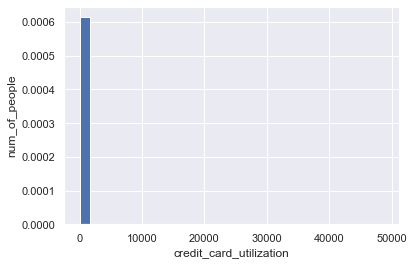

In [238]:
# credit_card_utilization

plt.hist(data=train_df, x='credit_card_utilization', density=True, bins=30)  # density=False would make counts
plt.ylabel('num_of_people')
plt.xlabel('credit_card_utilization');
#plt.ylim(0, 106000)

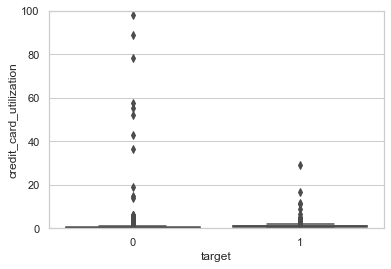

In [239]:
# credit_card_utilization scale 0-100

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="credit_card_utilization", data=data_train)
ax.set(ylim=(0, 100))
sns.set(rc = {'figure.figsize':(12,5)})

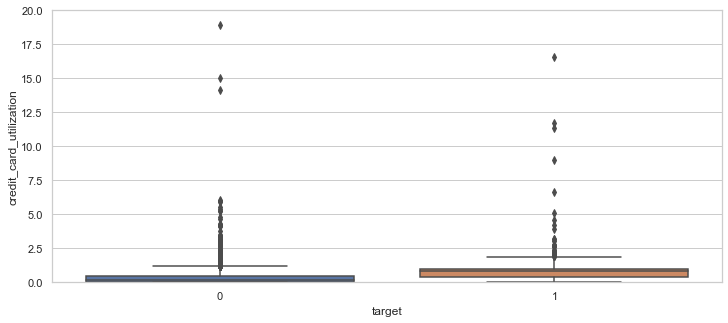

In [240]:
# credit_card_utilization scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="credit_card_utilization", data=data_train)
ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(12,5)})

[Text(0.5, 0, 'overdue_30_59_days'), Text(0, 0.5, 'amount_of_people')]

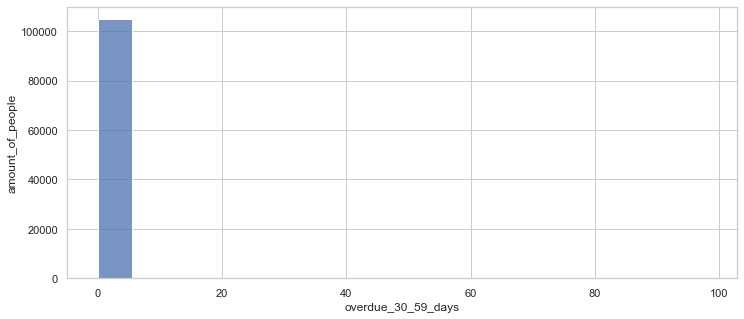

In [241]:
# overdue_30_59_days

sns.set_style("whitegrid")
ax = sns.histplot(data=data_train, x="overdue_30_59_days")
sns.set(rc = {'figure.figsize':(5,5)})
ax.set(xlabel='overdue_30_59_days', ylabel='amount_of_people')

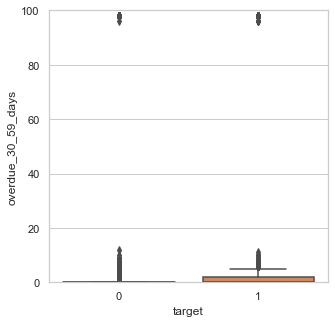

In [245]:
# overdue_30_59_days scale 0-100

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue_30_59_days", data=data_train)
ax.set(ylim=(0, 100))
sns.set(rc = {'figure.figsize':(12,5)})

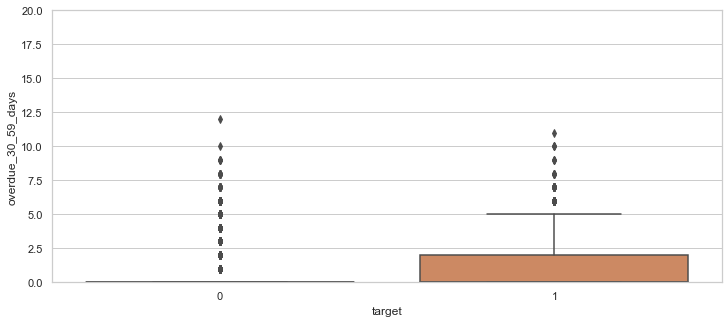

In [246]:
# overdue_30_59_days scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue_30_59_days", data=data_train)
ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

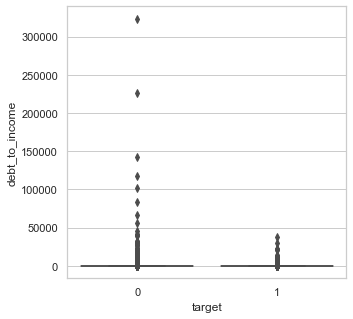

In [244]:
# debt_to_income scale 0-300000

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="debt_to_income", data=data_train)
sns.set(rc = {'figure.figsize':(5,5)})

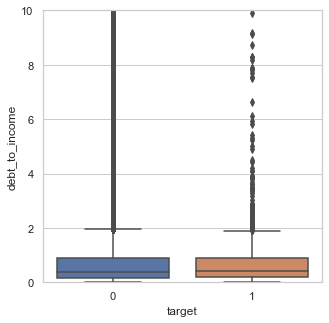

In [197]:
# debt_to_income scale 0-10

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="debt_to_income", data=data_train)
ax.set(ylim=(0, 10))
sns.set(rc = {'figure.figsize':(5,5)})

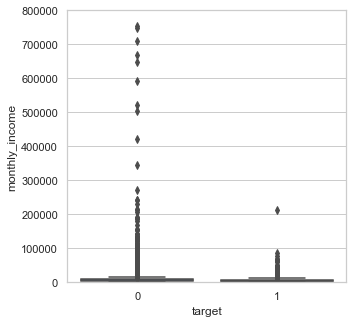

In [200]:
# monthly_income scale 0-800000

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="monthly_income", data=data_train)
ax.set(ylim=(0, 800000))
sns.set(rc = {'figure.figsize':(5,5)})

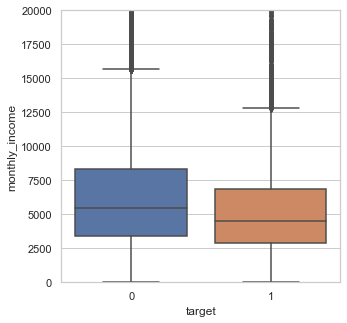

In [199]:
# monthly_income scale 0-10000

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="monthly_income", data=data_train)
ax.set(ylim=(0, 20000))
sns.set(rc = {'figure.figsize':(5,5)})

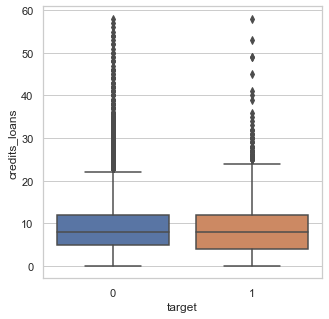

In [177]:
# credits_loans

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="credits_loans", data=data_train)
# ax.set(ylim=(0, 0.8e+06))
sns.set(rc = {'figure.figsize':(5,5)})

[(0.0, 35.0)]

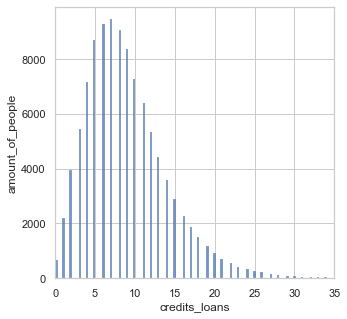

In [192]:
# credits_loans

sns.set_style("whitegrid")
ax = sns.histplot(data=train_df, x="credits_loans")
sns.set(rc = {'figure.figsize':(5,5)})
ax.set(xlabel='credits_loans', ylabel='amount_of_people')
ax.set(xlim=(0, 35))

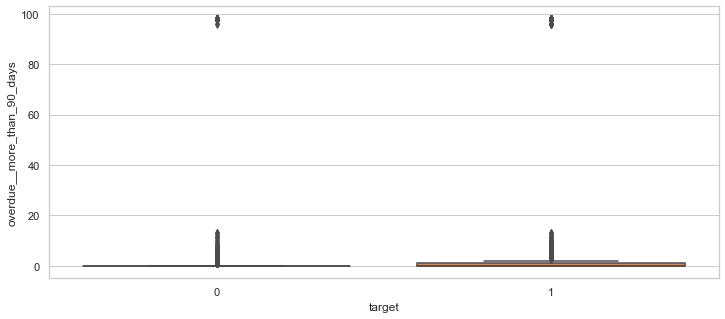

In [218]:
# overdue__more_than_90_days scale 0-100

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
# ax.set(ylim=(0, 0.8e+06))
sns.set(rc = {'figure.figsize':(5,5)})

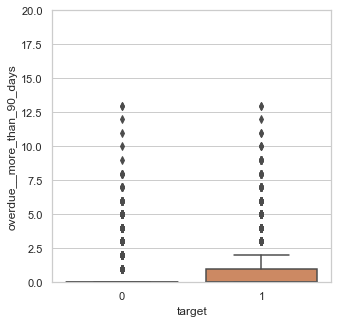

In [219]:
# overdue__more_than_90_days scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

[(0.0, 35.0)]

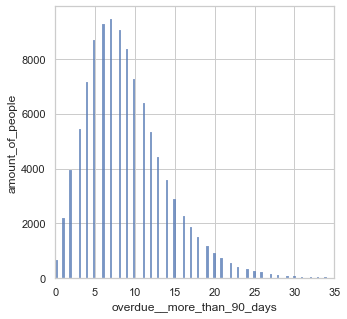

In [190]:
# overdue__more_than_90_days

sns.set_style("whitegrid")
ax = sns.histplot(data=train_df, x="credits_loans")
sns.set(rc = {'figure.figsize':(5,5)})
ax.set(xlabel='overdue__more_than_90_days', ylabel='amount_of_people')
ax.set(xlim=(0, 35))

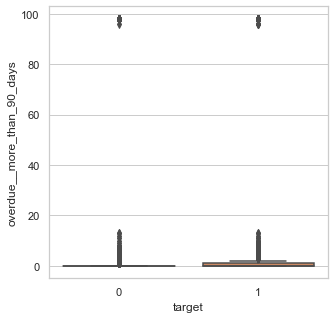

In [201]:
# mortgage_loans scale 0-100

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
#ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

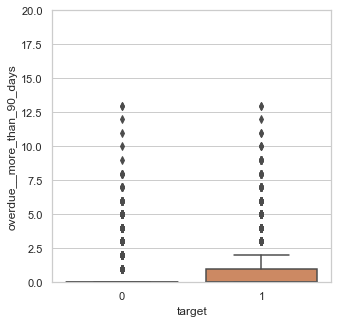

In [208]:
# mortgage_loans scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

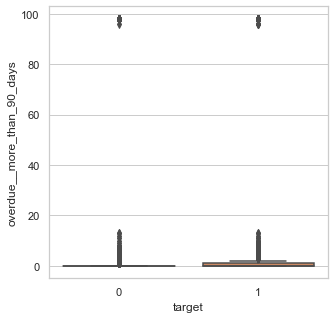

In [209]:
# overdue_60_89_days scale 0-100

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
# ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

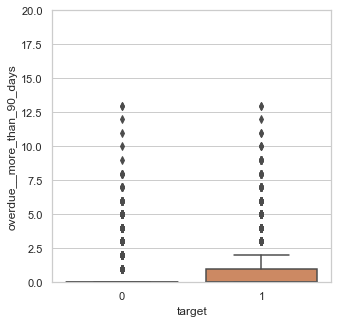

In [211]:
# overdue_60_89_days scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="overdue__more_than_90_days", data=data_train)
ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})

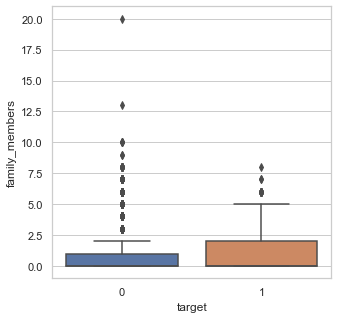

In [221]:
# family_members scale 0-20

sns.set_style("whitegrid")
ax = sns.boxplot(x="target", y="family_members", data=data_train)
# ax.set(ylim=(0, 20))
sns.set(rc = {'figure.figsize':(5,5)})
# plt.xlim(0, 10)

**There are 13 times fewer defaulted clients than non-defaulted ones** 

**This was taken into account when the XGB model was implemented**

13.949367088607595


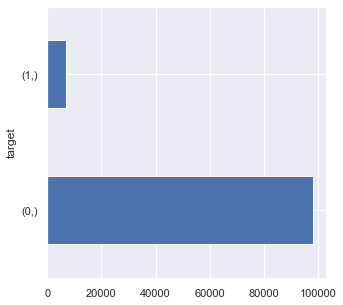

In [225]:
y.value_counts().plot.barh()
print(len(y[y['target']==0])/len(y[y['target']==1]))

**Number of gaps in each feature**

In [7]:
train_df.isnull().sum()

credit_card_utilization           0
age                               0
overdue_30_59_days                0
debt_to_income                    0
monthly_income                20993
credits_loans                     0
overdue__more_than_90_days        0
mortgage_loans                    0
overdue_60_89_days                0
family_members                 2805
dtype: int64

In [8]:
test_df.isnull().sum()

credit_card_utilization          0
age                              0
overdue_30_59_days               0
debt_to_income                   0
monthly_income                7545
credits_loans                    0
overdue__more_than_90_days       0
mortgage_loans                   0
overdue_60_89_days               0
family_members                 955
dtype: int64

**Replace gaps with median values**

In [12]:
train_df['monthly_income'].fillna(train_df['monthly_income'].median(), inplace=True)
train_df['family_members'].fillna(train_df['family_members'].median(), inplace=True)
test_df['monthly_income'].fillna(test_df['monthly_income'].median(), inplace=True)
test_df['family_members'].fillna(test_df['family_members'].median(), inplace=True)

**Check the matrix of the correlation coefficient of numerical features**

<AxesSubplot:>

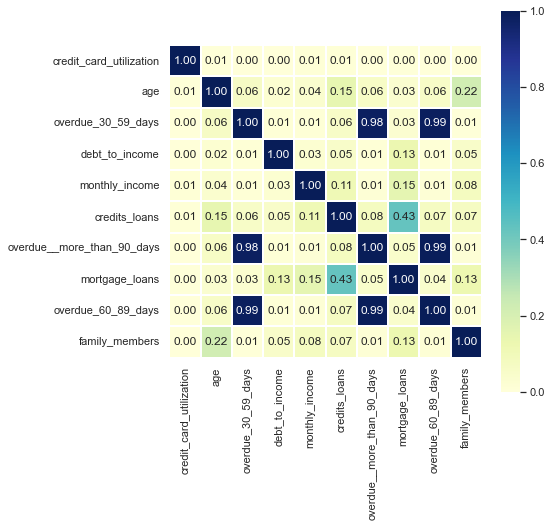

In [14]:
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(train_df.corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu")

**Standartizing for the data is not done since desicion tree based classifiers don't need it**

In [15]:
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler(with_mean=True, with_std=True)
# train_df = ss.fit_transform(train_df) 


## Decision tree without tuned params

In [89]:
first_tree = DecisionTreeClassifier(random_state=17, max_depth=3)
                                    
first_tree.fit(train_df, y)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [90]:
# make the code for writing the prediction for Kaggle to the file

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="index"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = test_sample['index'].values,
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [91]:
# make the prediction

first_tree_pred_probs = first_tree.predict_proba(test_df)[:, 1]

In [92]:
# write the prediction to the file

write_to_submission_file(first_tree_pred_probs, \
                         r'C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\trial_1.csv')

**Scores of Kaggle submission**
- Private: 0.81700
- Public: 0.81178

## DecisionTreeClassifier with tuned params

In [106]:
tree_params = {'max_depth': list(range(3, 8)), 
               'min_samples_leaf': list(range(5, 13))}

clf = DecisionTreeClassifier(random_state=17)

cv = StratifiedKFold(shuffle=True, n_splits=5)
locally_best_tree = GridSearchCV(estimator=clf, param_grid=tree_params, cv=5, n_jobs=-1)
locally_best_tree.fit(train_df, y) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12]})

In [107]:
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

({'max_depth': 4, 'min_samples_leaf': 5}, 0.937)

In [108]:
tuned_tree_pred_probs = locally_best_tree.predict_proba(test_df)[:, 1]

In [109]:
write_to_submission_file(tuned_tree_pred_probs, \
                         r'C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\trial_1.csv')

**Scores of Kaggle submission**
- Private: 0.83335
- Public: 0.83012

## RandomForest without tuned params

In [103]:
first_forest = RandomForestClassifier(random_state=17, n_jobs=-1)  
                                    
first_forest.fit(train_df, y)

RandomForestClassifier(n_jobs=-1, random_state=17)

In [104]:
first_forest_pred = first_forest.predict_proba(test_df)[:, 1]

In [105]:
write_to_submission_file(tuned_tree_pred_probs, \
                         r'C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\trial_1.csv')

**Scores of Kaggle submission**
- Private: 0.83335
- Public: 0.83012

## XGBoost + GridSearchCV & RandomisedSearchCV implementation

In [16]:
# make the split onto train and test parts

X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=42, stratify=y)

**Several GridSearchCV launches were made to find optimal values of the params**

In [36]:
# ## ROUND 1
# ## results {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 1}
# params = {
#     'max_depth':[3, 4, 5], 
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma': [0, 0.25, 1.0], 
#     'reg_lambda': [0, 1.0, 10.0], 
#     'scale_pos_weight': [1, 3, 5], 
# }

In [37]:
# ## ROUND 2
# ## 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 100, 'scale_pos_weight': 13
# params = {
#     'max_depth':[5, 6], 
#     'learning_rate': [0.1, 0.15, 0.2], 
#     'gamma': [0.25, 0.3, 0.35], 
#     'reg_lambda': [50, 100, 150], 
#     'scale_pos_weight': [13, 14, 15], 
# }

In [38]:
# ## ROUND 3
# ## {'gamma': 3, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 130, 'scale_pos_weight': 13}
# params = {
#     'max_depth':[5], 
#     'learning_rate': [0.05, 0.1, 0.15], 
#     'gamma': [0.3], 
#     'reg_lambda': [80, 110, 130],
#     'scale_pos_weight': [13], 
# }

In [39]:
# ## ROUND 4
# ## {'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 130, 'scale_pos_weight': 13}
# params = {
#     'max_depth':[5], 
#     'learning_rate': [0.05, 0.1, 0.15], 
#     'gamma': [0.3], 
#     'reg_lambda': [80, 110, 130],
#     'scale_pos_weight': [13], 
# }

In [46]:
# ## ROUND 5
# ## {'gamma': 0.25, 'learning_rate': 0.15, 'max_depth': 5, 'reg_lambda': 150, 'scale_pos_weight': 13}
# params = {
#     'max_depth':[5], 
#     'learning_rate': [0.15],
#     'gamma': [0.25], 
#     'reg_lambda': [150], 
#     'scale_pos_weight': [13],} 

In [ ]:
# GS_XGB2 = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 seed=42
#                                 ), 
#     param_grid=params, 
#     cv=5, 
#     scoring='roc_auc',
#     verbose=0,
#     n_jobs=-1)

# GS_XGB2.fit(X_train,
#             y_train,
#             verbose=False,
#             early_stopping_rounds=10,
#             eval_metric='auc',
#            eval_set=[(X_test, y_test)])

# print(GS_XGB2.best_params_)

**For more precise params tuning RandomizedSearchCV was used**

In [37]:
# RS_XGB2 = RandomizedSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic', 
#                                 seed=42,
#                                 ), 
#     param_distributions=params, 
#     n_iter=300,
#     cv=5, 
#     scoring='roc_auc',
#     verbose=0,
#     n_jobs=-1)
# RS_XGB2.fit(X_train,
#             y_train,
#             verbose=False,
#             # early_stopping_rounds=10,
#             eval_metric='aucpr',
#            eval_set=[(X_test, y_test)])
# print(RS_XGB2.best_params_)

**Final params**

In [110]:
XGB=xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.2444,
                                max_depth=5,
                                scale_pos_weight=13)

In [111]:
XGB.fit(X_train,
            y_train,
            verbose=False,
            early_stopping_rounds=10,    # The meaning of early_stopping_rounds is that if the ROC_AUC metric on the test 
            eval_metric='auc',           # dataset (eval_set) does not grow for ten iterations (trees building),                                   
            eval_set=[(X_test, y_test)]) # then the algorithm will initiate force trees bulding stoppage.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5533333333333333,
              enable_categorical=False, gamma=0.2444, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.081, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=117, scale_pos_weight=12,
              seed=42, subsample=0.7736842105263158, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [112]:
# Look at ROC_AUC

roc_auc_score(y_test, XGB.predict_proba(X_test)[:, 1])

0.870877155376401

In [ ]:
# make the prediction

XGB_pred = XGB.predict_proba(test_df)[:, 1]

In [ ]:
# write the prediction to the file

write_to_submission_file(XGB_pred, 
                         r'C:\\Users\\pavlo\\Desktop\\Py\\VTB_project\\bank scoring case data 2019\\trial_1.csv')

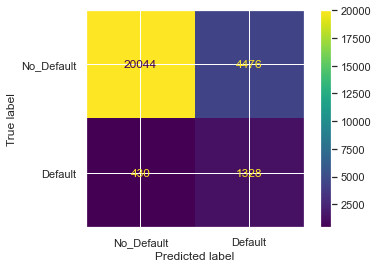

In [84]:
# Confusion Matrix

plot_confusion_matrix(XGB,
                      X_test,
                      y_test,
                     values_format='d',
                      display_labels=["No_Default", "Default"])

In [87]:
# Feature importance

pd.DataFrame(XGB.feature_importances_,  index=train_df.columns, columns=['importance'])

,importance
credit_card_utilization,0.162837
age,0.028350
overdue_30_59_days,0.254248
debt_to_income,0.018576
monthly_income,0.013593
credits_loans,0.022843
overdue__more_than_90_days,0.261360
mortgage_loans,0.029936
overdue_60_89_days,0.192203
family_members,0.016053


                       feature  importance
0     credit_card_utilization       447.0
3              debt_to_income       441.0
4              monthly_income       433.0
1                         age       343.0
5               credits_loans       302.0
7              mortgage_loans       162.0
2          overdue_30_59_days       133.0
6  overdue__more_than_90_days       116.0
9              family_members       114.0
8          overdue_60_89_days       100.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

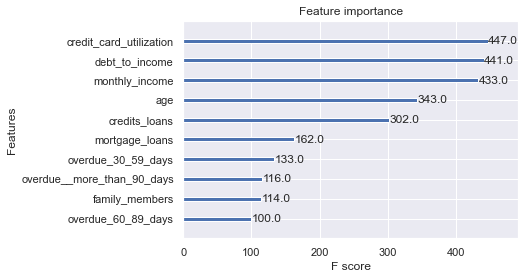

In [86]:
import pandas as pd
xgb_fea_imp=pd.DataFrame(list(XGB.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp.csv')

from xgboost import plot_importance
plot_importance(XGB, )

## Voting ensemble

**This Voting ensemble includes XGBoost models with previously found optimal params values that differ from each other only by the scale_pos_weight param value in the range from 1 to 13 with the pace of 0.5**

In [ ]:
import numpy as np
from sklearn.ensemble import VotingClassifier
models = list()
models.append(('clf1', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=2)))
models.append(('clf1_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=2.5)))
models.append(('clf2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=3)))
models.append(('clf2_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=3.5)))
models.append(('clf3', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=4)))
models.append(('clf3_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=4.5)))
models.append(('clf4', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=5)))
models.append(('clf4_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=5.5)))
models.append(('clf5', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=6)))
models.append(('clf5_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=6.5)))
models.append(('clf6', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=7)))
models.append(('clf6_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=7.5)))
models.append(('clf7', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=8)))
models.append(('clf7_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=8.5)))
models.append(('clf8', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=9)))
models.append(('clf8_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=9.5)))
models.append(('clf9', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=10)))
models.append(('clf9_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=10.5)))
models.append(('clf10', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=11)))
models.append(('clf10_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=11.5)))
models.append(('clf11', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=12)))
models.append(('clf11_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=12.5)))
models.append(('clf12', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=13)))
models.append(('clf12_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=13.5)))
models.append(('clf13', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=1)))
models.append(('clf13_2', xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42, 
                                subsample=0.7736842105263158, 
                                colsample_bytree=0.5533333333333333,
                                reg_lambda=117,
                                learning_rate=0.081,
                                gamma=0.24,
                                max_depth=5,
                                scale_pos_weight=1.5)))
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(train_df, y)

In [ ]:
ensemble_pred = ensemble.predict_proba(test_df)[:, 1]

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="index"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = test_sample['index'].values,
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(ensemble_pred, r'./trial_1.csv')